## 波士顿房价数据集

数据点较少，输入数据的每个特征都有不同的取值范围。

### 加载波士顿房价数据

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

房价大多数在10000～50000美元之间。

## 准备数据

将取值范围差异很大的数据输入到神经网络中，会使学习变得十分困难。

需对每个特征做标准化，即对输入数据的每个特征，减去特征平均值，再除以标准差，这样得到的特征平均值为0，标准差为1。

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

用于测试数据标准化的均值和标准差都是在训练数据上计算得到的。在工作流程中，不能使用在测试数据上计算得到的任何结果，即使是数据标准化这么简单的事情也不行。

## 构建网络

数据较少，使用小的网络。

一般来说，训练数据越少，过拟合会越严重，而较小的网络可以降低过拟合。

### 模型定义

In [6]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    
    model.add(layers.Dense(64, activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=['mae'])
    
    return model

最后一层只有1个单元，没有激活，是一个线性层，输出线性标量。

使用mse损失函数，MAE（预测值和目标值之差的绝对值）作为监控指标。

## 利用K折验证来验证你的方法

将数据划分k个模型，每个模型划分k个分区。

每个模型每次在k-1个分区上训练，在剩下的一个分区上验证。

最终验证分数等于个验证分数的平均值。

### K折验证

In [7]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    #第k个分区的数据和标签
    val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples:(i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)   #静默模式，verbose=0 不输出日志信息
    #在验证数据上评估模型
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
processing fold # 1
processing fold # 2
processing fold # 3


In [8]:
print(all_scores)
print(np.mean(all_scores))

[2.098391015930931, 2.141145937513597, 2.8568313711940654, 2.3336834482627338]
2.357512943225332


每次得到的验证分数有很大差异，平均分数是最可靠的指标。

考虑到实际价格范围在1W～5W，目标与预测之间2500美元左右的误差还是可以接受的。

## 保存每折的验证结果

让训练时间更长一点，达到500个轮次。为了记录模型在每轮的表现，我们需要修改训练循环，以保存每轮的验证分数记录。

In [9]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    #第k个分区的数据和标签
    val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples:(i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)   #静默模式，verbose=0 不输出日志信息
    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


### 计算所有轮次中的K折验证分数平均值

In [10]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### 绘制验证分数

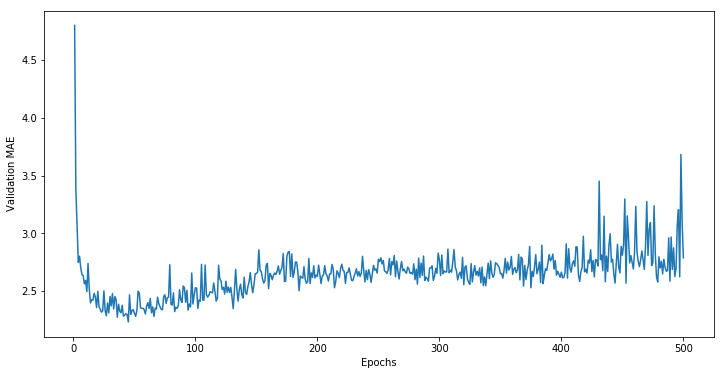

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,6))
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

纵轴范围较大，且数据方差较大。

    删除前10个点。
    将每个数据点替换为前面数据点的指数移动平均值，以得到光滑的曲线。

### 绘制验证分数（删除前10个点）

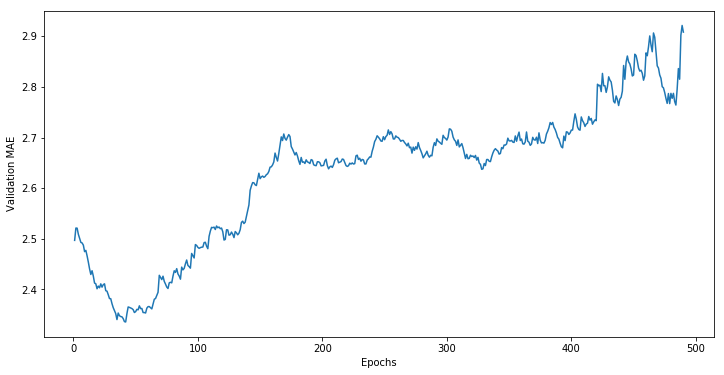

In [12]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.figure(figsize=(12,6))
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

可以看出，验证MAE在80轮后不再显著降低，之后就开始过拟合。

### 训练最终模型

In [13]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16,verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


In [14]:
test_mae_score

2.6853803372850606